# Model4: Comments classification using BERT

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

## Data preparation

In [26]:
df1 = pd.read_csv('../../data/semeval2017_twitter/combined_sentiment_dataset.csv')
df2 = pd.read_csv('../../data/YouTube_Comments_Dataset/YoutubeCommentsDataSet.csv')

In [27]:
df1.head()

,text,label,split,sentiment
0,"""QT @user In the original draft of the 7th boo...",2,train,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,train,neutral
2,Sorry bout the stream last night I crashed out...,1,train,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,train,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,train,positive


In [28]:
df1['label'].value_counts()

label
1    27479
2    21043
0    11377
Name: count, dtype: int64

2 - positive; 1 - neutral; 0 - negative

In [29]:
df1 = df1[["text", "label"]]
df1.columns = ["Comment", "Sentiment"]

In [30]:
df2.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [31]:
df2["Sentiment"] = df2["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).infer_objects(copy=False)
df2["Sentiment"] = df2["Sentiment"].astype(int)

C:\Users\davyd\AppData\Local\Temp\ipykernel_20388\1817287716.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2["Sentiment"] = df2["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).infer_objects(copy=False)


In [32]:
df = pd.concat([df1, df2], ignore_index=True)

## Visualizations

### Sentiment Distribution

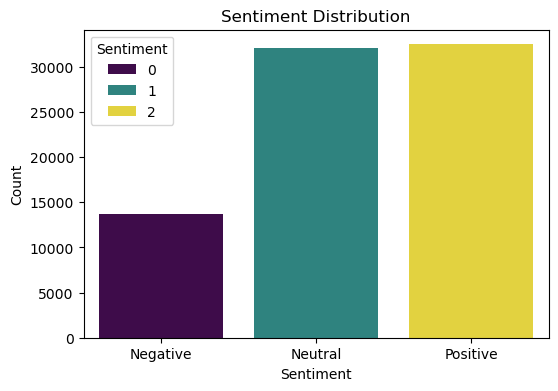

In [33]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Sentiment"], palette="viridis", hue = df["Sentiment"])
plt.xticks(ticks=[0, 1, 2], labels=["Negative", "Neutral", "Positive"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

There are much more less number of negative comments compared to positive and neutral comments.

### Word Cloud for Each Sentiment

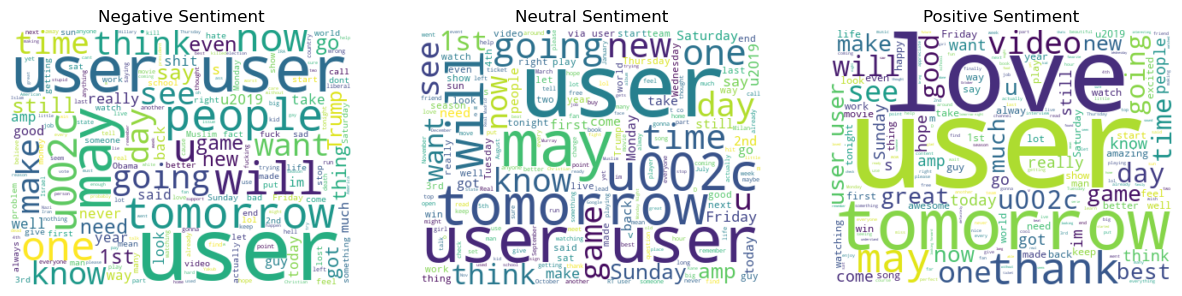

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
for sentiment, ax in zip(sentiment_labels.keys(), axes):
    text = " ".join(df[df["Sentiment"] == sentiment]["Comment"].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{sentiment_labels[sentiment]} Sentiment")
plt.show()

There are no significant differences between the word clouds of different sentiments. So it may be hard to classify the comments based on the words. Also there are a lot of "user" words so, try to remove them.

In [35]:
import re

def clean_comment(text):
    text = re.sub(r"@user", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"(^|\s)QT\s", "", text) 
    text = re.sub(r".*?:\s", "", text)
    text = re.sub(r"\\u[\dA-Fa-f]{4}", "", text) 
    text = text.strip()
    return text

In [36]:
df["Comment"] = df["Comment"].astype(str)
cleaned_dataset = [clean_comment(text) for text in df["Comment"]]
df["Comment"] = cleaned_dataset

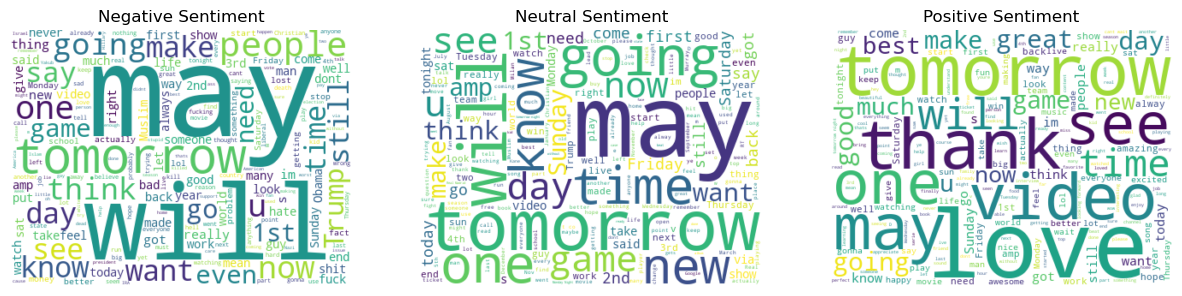

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
for sentiment, ax in zip(sentiment_labels.keys(), axes):
    text = " ".join(df[df["Sentiment"] == sentiment]["Comment"].astype(str))
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{sentiment_labels[sentiment]} Sentiment")
plt.show()

Now sentences are more clear and for model it will be easier to classify them.

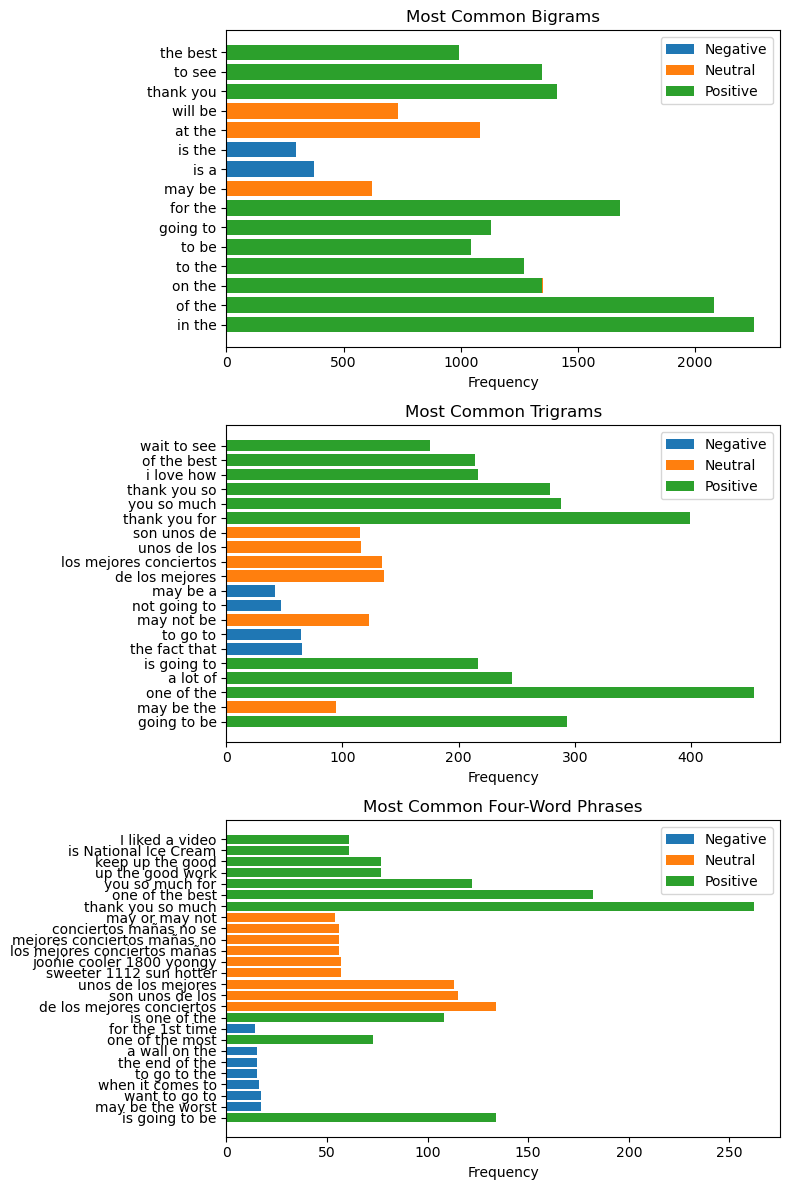

In [38]:
from collections import Counter
from itertools import islice

def get_ngrams(texts, n=3):
    ngrams = Counter()
    for text in texts:
        words = text.split()
        ngrams.update(zip(*[words[i:] for i in range(n)]))
    return ngrams.most_common(10)  

sentiment_groups = df.groupby("Sentiment")["Comment"].apply(list)
ngrams_data = {sent: {n: get_ngrams(texts, n) for n in [2, 3, 4]} for sent, texts in sentiment_groups.items()}

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
ngram_titles = ["Most Common Bigrams", "Most Common Trigrams", "Most Common Four-Word Phrases"]

for idx, n in enumerate([2, 3, 4]):
    ax = axes[idx]
    bigram_counts = {sentiment_labels[sent]: ngrams_data[sent][n] for sent in sentiment_labels.keys()}
    
    for sentiment, data in bigram_counts.items():
        phrases, counts = zip(*data) if data else ([], [])
        phrases = [" ".join(phrase) for phrase in phrases]  # Convert tuple to string
        ax.barh(phrases, counts, label=sentiment)
    
    ax.set_title(ngram_titles[idx])
    ax.set_xlabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()


There are no significant differences between phrases of different sentiments. So it may be hard to classify the comments based on the phrases. With the help of BERT, we can classify the comments more accurately.

## Data Preprocessing

In [39]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [40]:
class CommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length=128):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.comments)
    
    def __getitem__(self, idx):
        text = str(self.comments[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [41]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df["Comment"], df["Sentiment"], test_size=0.1, random_state=42)

In [42]:
# Create dataset objects
train_dataset = CommentDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
val_dataset = CommentDataset(val_texts.tolist(), val_labels.tolist(), tokenizer)

In [43]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

## Building the Model

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [45]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

Epoch 1, Loss: 0.6110, Accuracy: 0.7289
Epoch 2, Loss: 0.4472, Accuracy: 0.8117
Epoch 3, Loss: 0.2925, Accuracy: 0.8832


## Model Evaluation

In [46]:
from sklearn.metrics import classification_report
model.eval()
preds_list, true_list = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)
        preds_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
print(classification_report(true_list, preds_list, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.66      0.75      0.70      1393
     Neutral       0.77      0.56      0.65      3197
    Positive       0.74      0.89      0.81      3241

    accuracy                           0.73      7831
   macro avg       0.72      0.73      0.72      7831
weighted avg       0.74      0.73      0.73      7831



Accuracy 73% is not the best result, so continue training the model on 2 additional epochs.

In [47]:
# Continue Training loop for 2 more epochs
epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


Epoch 1, Loss: 0.1771, Accuracy: 0.9331
Epoch 2, Loss: 0.1230, Accuracy: 0.9554


In [48]:
from sklearn.metrics import classification_report
model.eval()
preds_list, true_list = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)
        preds_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
print(classification_report(true_list, preds_list, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.71      0.68      0.69      1393
     Neutral       0.71      0.69      0.70      3197
    Positive       0.79      0.82      0.80      3241

    accuracy                           0.74      7831
   macro avg       0.73      0.73      0.73      7831
weighted avg       0.74      0.74      0.74      7831



After 2 additional epochs, the accuracy increased to 74%, on training set it incerased from 0.88 to 0.95, but test set does not show significant improvement.

### Confusion Matrix

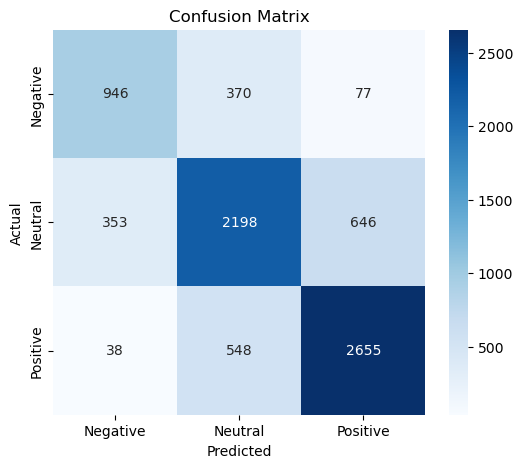

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_list, preds_list)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Model often confuses neutral and positive comments and neutral and negative comments. This is not such a big problem, because neutral comments are not so different from positive and negative comments. Model made only 115 mistakes in predicting negative comments, as positive comments and positive comments as negative comments, so that's not a big problem.

## Save, load and test the model

In [52]:
torch.save(model.state_dict(), "model4.pth")

In [55]:
load_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
load_model.load_state_dict(torch.load("model4.pth"))
load_model.to(device)
load_model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [56]:
def predict_sentiment(text, model, tokenizer):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        prediction = output.logits.argmax(dim=1).item()
    
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[prediction]

In [57]:
def predict_sentiment(text, model, tokenizer):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask=attention_mask)
        prediction = output.logits.argmax(dim=1).item()
    
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[prediction]

In [64]:
test_sentences = [
    "This video is amazing! I learned so much.",
    "Terrible quality, I want my time back.",
    "It's okay, not the best but not the worst either.",
    "Absolutely fantastic! Highly recommend this channel.",
    "I'm very disappointed with the content.",
    "Mediocre video, nothing special.",
    "Loved it! Will definitely subscribe.",
    "Worst video ever, do not watch this.",
    "Quite satisfied with the information provided.",
    "Not happy with the video at all.",
    "The video was informative but could be better.",
    "I found the content to be average.",
    "The quality of the video was decent.",
    "It was an okay watch, nothing extraordinary.",
    "The video was neither good nor bad.",
    "I have mixed feelings about this video.",
    "The content was somewhat useful.",
    "It was a fair video, not too impressive.",
    "The video was alright, could use some improvements.",
    "I don't have strong opinions about this video."
]

In [65]:
for sentence in test_sentences:
    print(f"Sentence: '{sentence}' -> Predicted Sentiment: {predict_sentiment(sentence, model, tokenizer)}")

Sentence: 'This video is amazing! I learned so much.' -> Predicted Sentiment: Positive
Sentence: 'Terrible quality, I want my time back.' -> Predicted Sentiment: Negative
Sentence: 'It's okay, not the best but not the worst either.' -> Predicted Sentiment: Neutral
Sentence: 'Absolutely fantastic! Highly recommend this channel.' -> Predicted Sentiment: Positive
Sentence: 'I'm very disappointed with the content.' -> Predicted Sentiment: Negative
Sentence: 'Mediocre video, nothing special.' -> Predicted Sentiment: Negative
Sentence: 'Loved it! Will definitely subscribe.' -> Predicted Sentiment: Positive
Sentence: 'Worst video ever, do not watch this.' -> Predicted Sentiment: Negative
Sentence: 'Quite satisfied with the information provided.' -> Predicted Sentiment: Positive
Sentence: 'Not happy with the video at all.' -> Predicted Sentiment: Negative
Sentence: 'The video was informative but could be better.' -> Predicted Sentiment: Positive
Sentence: 'I found the content to be average.' -

Model more often predicts positive or negative comments for neutral comments, so let's check the confidence of the model for the neutral comments.